# Series 7: Non-Negative Matrix Factorization

## Problem 2 (Implementing NMF for Image Analysis)

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

### Data wrangling

In [5]:
image_dir = "data/CroppedYale/"

files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")

imgs = [Image.open(image_dir + files[i]) for i in range(n)]

Loading 38 images


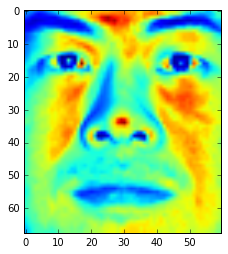

In [6]:
plt.imshow(imgs[1]) # Display first image

In [7]:
# Assume all images have the same size
img0 = imgs[0]
width, height = img0.size

# Compute input matrix X
X_list = [np.ravel(imgs[i].getdata()) for i in range(n)]
X = np.array(X_list, dtype=np.float32)
print(X.shape)

(38, 4080)


## Alternating least-squares

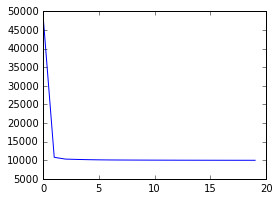

In [69]:
k = 3
epochs = 20
errors = np.zeros(epochs)

N, M = X.shape
U = np.random.random([k, N])
V = np.random.random([k, M])

for epoch in range(epochs):
    A_V = np.dot(U, U.T)
    B_V = np.dot(U, X)
    V_new, _, _, _ = np.linalg.lstsq(A_V, B_V)
    V_new[V_new < 0] = 0
    
    # Use the new V to update U.
    A_U = np.dot(V_new, V_new.T)
    B_U = np.dot(V_new, X.T)
    U_new, _, _, _ = np.linalg.lstsq(A_U, B_U)
    U_new[U_new < 0] = 0
    
    reconstructed_X = np.dot(U.T, V)
    error = np.linalg.norm(X - reconstructed_X)
    errors[epoch] = error
    
    U = U_new
    V = V_new
    
rcParams['figure.figsize'] = 4, 3
plt.plot(np.arange(epochs), errors)

(3, 4080)


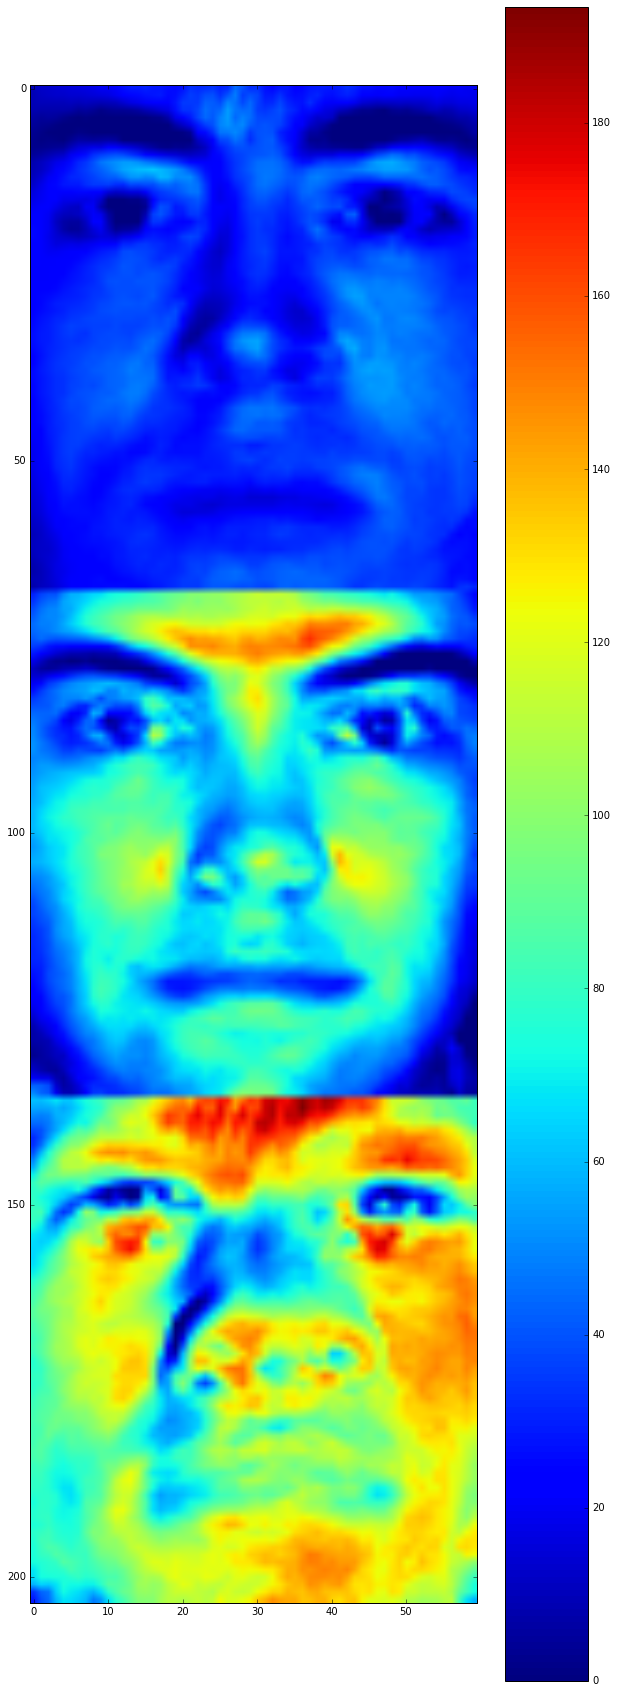

In [70]:
# Plot the resulting images stored in the columns of V
from pylab import rcParams
rcParams['figure.figsize'] = 10, 30
MAX_IMAGES_TO_SHOW = 30
print(V.shape)
new_images_stacked = np.reshape(V[:MAX_IMAGES_TO_SHOW,:], (-1, width))
fig1 = plt.figure()
# plt.imshow(new_images_stacked, cmap='Greys')
plt.imshow(new_images_stacked)
plt.colorbar()